<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%A2%D0%B2%D0%BE%D1%80%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%BE_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D0%B5_%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ООО "Университет Цифровых Технологий платформа 3"

# Творчество нейросетей. Генеративные состязательные сети


## Теория

На предыдущих занятиях рассматривался VAE как сеть для генерации случайных реалистичных изображений. Для генерации изображения на вход обученному декодеру подается случайный вектор $z$ из скрытого пространства.

Генеративно-состязательные сети (Generative Adversarial Networks, GAN), впервые
представленные в 2014 году Яном Гудфеллоу (Ian Goodfellow) и его коллегами
, — альтернатива вариационным автокодировщикам. Они позволяют генерировать очень реалистичные искусственные изображения, статистически неотличимые от настоящих.

Генератор в этой архитектуре похож на декодер VAE. Он получает на вход вектор (точку) $z$ и выдает изображение, соответствующее этой точке. Однако обучение генератора происходит совершенно иначе. Для обучения служит генеративно-состязательная сеть, состоящая из генератора и дискриминатора. Генератор обучается выдавать реалистичные изображения, максимально похожие на изображения из обучающего набора. Дискриминатор учится отличать истинные изображения (из обучающего набора) от фейковых, создаваемых генератором. Таким образом, генератор и дискриминатор состязаются в процессе обучения.


Более детально, обучение дискриминатора происходит так: ему на вход попеременно подаются изображения из обучающего набора и сгенерированные генератором. В качестве меток используются (например) числа 1 и 0 (для истинных и фейковых изображений соответственно). Дискриминатор является бинарным классификатором, с бинарной кросс-энтропией в качестве функции потерь. После обработки батча изображений делается градиентный шаг, обновляются веса дискриминатора.

Далее делается шаг обучения генератора. На вход генератору подается батч случайных векторов скрытого пространства. Выход генератора подается на вход дискриминатору. На время обучения веса дискриминатора фиксируются. Выход дискриминатора сравнивается с единицами - тем значением, которое должно получится если генератору удается обмануть дискриминатор. В этом режиме дискриминатор является фактически вычислителем функции потерь для генератора. Вычисляется градиент функции потерь по отношению к весам генератора и делается градиентный шаг, т.е. обновляются веса генератора.

На этом эпоха обучения завершается, и цикл повторяется снова и снова. В результате генератор обучается выдавать изображения, похожие на тренировочные, а дискриминатор обучается отличать подделки.

Для успешного обучения очень важна сбалансированность скорости обучения генератора и дискриминатора. Если дискриминатор с самого начала будет легко выявлять все подделки, то градиент функции потерь будет равен нулю и генератор не сможет обучиться. Если, наоборот, дискриминатор не способен отличать подделки, то и в этом случае градиент обнулится и обучение генератора остановится.





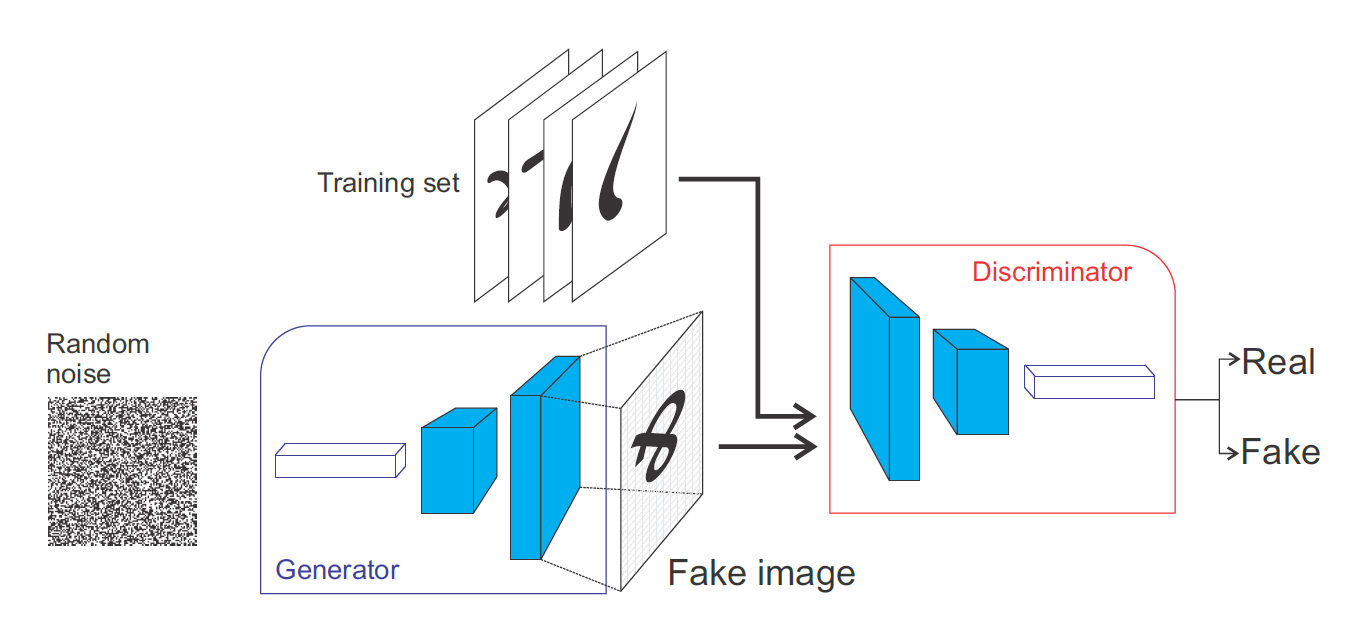

## Простой GAN 

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate, Embedding, multiply 
from tensorflow.keras.layers import LeakyReLU 
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam 

import matplotlib.pyplot as plt 
import os
import numpy as np 

Рассмотрим простейший, классический GAN на примере датасета MNIST.

Особенностью обучения GAN является нормировка изображений от -1 до +1 и использование активации LeakyReLU

In [ ]:
img_shape = (28, 28, 1) # Размерность входных данных для набора Mnist
latent_dim = 100 # размерность скрытого пространства
batch_size = 128 
num_classes = 10 # 10 цифр
optimizer = Adam(0.0002, 0.5) 

### Полносвязный GAN

In [ ]:
def build_generator(latent_dim=100):
    model = Sequential()

    model.add(Dense(256, input_shape=(latent_dim,)))
    model.add(LeakyReLU(alpha=0.2)) # альтернативное добавление функции активации - отдельным слоем
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [ ]:
def build_discriminator(): 

    img_shape = (28, 28, 1)
    
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [ ]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5

In [ ]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

Создаем каталог для сохранения промежуточных сгенерированных изображений.

In [ ]:
os.makedirs("images", exist_ok=True)
os.makedirs("images2", exist_ok=True) # для генеративной сети с условием (for conditional GAN)

### Функции для визуализации

In [ ]:
def plot_history(history, figsize=(16, 10), ylim=None):
    plt.figure(figsize=figsize)
    plt.subplot(2,1,1)
    plt.plot(history[:, 0, 0], 'o', markersize=2, label="Ошибка дискриминатора real")
    plt.plot(history[:, 1, 0], 'o', markersize=2, label="Ошибка дискриминатора fake")
    plt.plot(history[:, 2, 0], 'o', markersize=2, label="Ошибка генератора")
    if ylim:
        plt.ylim(ylim)
    plt.legend()
    plt.grid()
    plt.subplot(2,1,2)
    plt.plot(np.exp(-history[:, 0, 0]), 'o', markersize=2, label="Точность дискриминатора real")
    plt.plot(np.exp(-history[:, 1, 0]), 'o', markersize=2, label="Точность дискриминатора fake")
    plt.plot(np.exp(-history[:, 2, 0]), 'o', markersize=2, label="Точность генератора")
    plt.grid()
    plt.ylim(0., 1.1)
    plt.legend();

Функция для сохранения картинок в каталоге

In [ ]:
def save_imgs(generator, epoch, latent_dim=latent_dim, dir='images'):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    # Приводим к диапазону 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("%s/mnist_%05d.png" % (dir, epoch))
    plt.close()

Вывод генерируемых картинок

In [ ]:
def plot_imgs(generator, latent_dim):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    # Приводим к диапазону 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

### Функция обучения

In [ ]:
def train(generator, discriminator, epochs, batch_size=128, save_interval=50, latent_dim=latent_dim):

    # Load the dataset
    # загружаем датасет
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    # Приводим к диапазону от -1 до 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    history = []

    z = Input(shape=(latent_dim,))
    img = generator(z)

    # For the combined model we will only train the generator
    # для комбинированной модели тренируем только генератор
    discriminator.trainable = False

    # The valid takes generated images as input and determines validity
    # В valid будет находиться прогноз, реальные или фейковые изображения поданы в дискриминатор
    valid = discriminator(img)

    # The combined model  (stacked generator and discriminator) takes
    # noise as input => generates images => determines validity
    # Комбинированная модель, составленная из генератора и дискриминатора,
    # принимает на вход шум, из которого генератор создаёт фейковые изображения,
    # а дискриминатор потом оценивает их на валидность 
    combined = Model(z, valid)
    combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


    for epoch in range(epochs):

        # ---------------------------
        #  Train Discriminator
        # тренировка дискриминатора
        # ---------------------------

        # Select a random half batch of images
        # выбираем случайным образом половину пакета изображений
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, latent_dim))

        # Generate a half batch of new images
        # создаём половину пакета фейковых изображений
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        # тренировка дискриминатора
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        # ---------------------
        #  Train Generator
        # тренировка генератора
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        # генератор старается сделать такие изображения, которые
        # дискриминатор примет за настоящие, и даст им оценку как настоящим
        valid_y = np.array([1] * batch_size)

        # Train the generator
        # тренировка генератора
        g_loss = combined.train_on_batch(noise, valid_y)

        # If at save interval => save generated image samples
        # сохраняем картинки на определённом этапе обучения
        if (epoch + 1) % save_interval == 0:
            plot_imgs(generator, latent_dim)

        if (epoch + 1) % 100 == 0:
            print ("%d [D loss real: %.3f, acc.: %.2f%%] [D loss fake: %.3f, acc.: %.2f%%] [G loss: %.3f, acc.: %.2f%%]" % 
                   (epoch + 1, d_loss_real[0], 100*d_loss_real[1], d_loss_fake[0], 100*d_loss_fake[1], g_loss[0], 100*g_loss[1]))

        history.append((d_loss_real, d_loss_fake, g_loss))
    return np.array(history)

### Обучение

11493376/11490434 [==============================] - 0s 0us/step
100 [D loss real: 0.082, acc.: 98.44%] [D loss fake: 0.357, acc.: 79.69%] [G loss: 3.406, acc.: 0.00%]
200 [D loss real: 0.235, acc.: 93.75%] [D loss fake: 0.543, acc.: 65.62%] [G loss: 2.497, acc.: 3.12%]
300 [D loss real: 0.487, acc.: 82.81%] [D loss fake: 0.924, acc.: 3.12%] [G loss: 0.801, acc.: 47.66%]
400 [D loss real: 0.532, acc.: 87.50%] [D loss fake: 0.808, acc.: 9.38%] [G loss: 0.700, acc.: 63.28%]
500 [D loss real: 0.521, acc.: 95.31%] [D loss fake: 0.723, acc.: 35.94%] [G loss: 0.785, acc.: 18.75%]
600 [D loss real: 0.497, acc.: 93.75%] [D loss fake: 0.714, acc.: 35.94%] [G loss: 0.805, acc.: 5.47%]
700 [D loss real: 0.475, acc.: 98.44%] [D loss fake: 0.721, acc.: 50.00%] [G loss: 0.799, acc.: 25.78%]
800 [D loss real: 0.574, acc.: 68.75%] [D loss fake: 0.741, acc.: 37.50%] [G loss: 0.822, acc.: 19.53%]
900 [D loss real: 0.544, acc.: 79.69%] [D loss fake: 0.667, acc.: 65.62%] [G loss: 0.924, acc.: 1.56%]


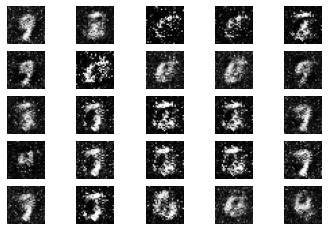

1000 [D loss real: 0.520, acc.: 73.44%] [D loss fake: 0.679, acc.: 57.81%] [G loss: 0.907, acc.: 5.47%]
1100 [D loss real: 0.520, acc.: 81.25%] [D loss fake: 0.634, acc.: 70.31%] [G loss: 0.950, acc.: 3.91%]
1200 [D loss real: 0.533, acc.: 76.56%] [D loss fake: 0.621, acc.: 71.88%] [G loss: 1.006, acc.: 2.34%]
1300 [D loss real: 0.521, acc.: 78.12%] [D loss fake: 0.596, acc.: 76.56%] [G loss: 0.996, acc.: 4.69%]
1400 [D loss real: 0.581, acc.: 56.25%] [D loss fake: 0.632, acc.: 68.75%] [G loss: 1.007, acc.: 14.84%]
1500 [D loss real: 0.514, acc.: 81.25%] [D loss fake: 0.609, acc.: 71.88%] [G loss: 0.971, acc.: 15.62%]
1600 [D loss real: 0.563, acc.: 75.00%] [D loss fake: 0.630, acc.: 65.62%] [G loss: 0.898, acc.: 15.62%]
1700 [D loss real: 0.565, acc.: 79.69%] [D loss fake: 0.621, acc.: 71.88%] [G loss: 0.903, acc.: 20.31%]
1800 [D loss real: 0.508, acc.: 76.56%] [D loss fake: 0.590, acc.: 71.88%] [G loss: 0.959, acc.: 12.50%]
1900 [D loss real: 0.580, acc.: 68.75%] [D loss fake: 0.630

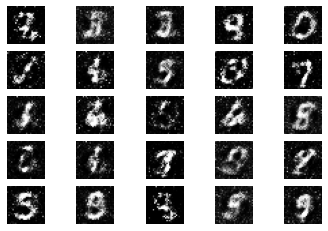

2000 [D loss real: 0.569, acc.: 71.88%] [D loss fake: 0.597, acc.: 71.88%] [G loss: 0.915, acc.: 17.19%]
2100 [D loss real: 0.623, acc.: 70.31%] [D loss fake: 0.656, acc.: 59.38%] [G loss: 0.929, acc.: 14.84%]
2200 [D loss real: 0.579, acc.: 68.75%] [D loss fake: 0.653, acc.: 60.94%] [G loss: 0.963, acc.: 20.31%]
2300 [D loss real: 0.548, acc.: 84.38%] [D loss fake: 0.672, acc.: 64.06%] [G loss: 0.946, acc.: 13.28%]
2400 [D loss real: 0.505, acc.: 84.38%] [D loss fake: 0.625, acc.: 64.06%] [G loss: 0.878, acc.: 19.53%]
2500 [D loss real: 0.596, acc.: 70.31%] [D loss fake: 0.674, acc.: 59.38%] [G loss: 0.884, acc.: 20.31%]
2600 [D loss real: 0.595, acc.: 65.62%] [D loss fake: 0.596, acc.: 75.00%] [G loss: 0.909, acc.: 24.22%]
2700 [D loss real: 0.612, acc.: 68.75%] [D loss fake: 0.629, acc.: 65.62%] [G loss: 0.915, acc.: 17.19%]
2800 [D loss real: 0.644, acc.: 62.50%] [D loss fake: 0.628, acc.: 65.62%] [G loss: 0.854, acc.: 24.22%]
2900 [D loss real: 0.686, acc.: 54.69%] [D loss fake: 0

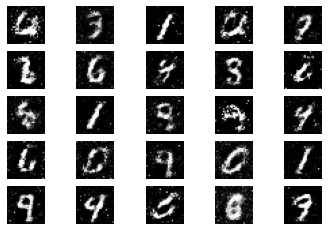

3000 [D loss real: 0.621, acc.: 59.38%] [D loss fake: 0.621, acc.: 70.31%] [G loss: 0.941, acc.: 13.28%]
3100 [D loss real: 0.703, acc.: 53.12%] [D loss fake: 0.627, acc.: 71.88%] [G loss: 0.914, acc.: 15.62%]
3200 [D loss real: 0.618, acc.: 68.75%] [D loss fake: 0.652, acc.: 64.06%] [G loss: 0.857, acc.: 25.78%]
3300 [D loss real: 0.633, acc.: 67.19%] [D loss fake: 0.651, acc.: 64.06%] [G loss: 0.802, acc.: 32.03%]
3400 [D loss real: 0.586, acc.: 65.62%] [D loss fake: 0.689, acc.: 59.38%] [G loss: 0.847, acc.: 28.12%]
3500 [D loss real: 0.649, acc.: 57.81%] [D loss fake: 0.675, acc.: 62.50%] [G loss: 0.862, acc.: 29.69%]
3600 [D loss real: 0.564, acc.: 76.56%] [D loss fake: 0.675, acc.: 60.94%] [G loss: 0.857, acc.: 22.66%]
3700 [D loss real: 0.644, acc.: 62.50%] [D loss fake: 0.688, acc.: 48.44%] [G loss: 0.835, acc.: 28.91%]
3800 [D loss real: 0.591, acc.: 73.44%] [D loss fake: 0.637, acc.: 64.06%] [G loss: 0.874, acc.: 29.69%]
3900 [D loss real: 0.685, acc.: 57.81%] [D loss fake: 0

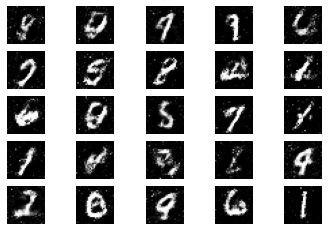

4000 [D loss real: 0.695, acc.: 43.75%] [D loss fake: 0.711, acc.: 51.56%] [G loss: 0.819, acc.: 30.47%]
4100 [D loss real: 0.669, acc.: 54.69%] [D loss fake: 0.695, acc.: 53.12%] [G loss: 0.817, acc.: 29.69%]
4200 [D loss real: 0.632, acc.: 68.75%] [D loss fake: 0.669, acc.: 64.06%] [G loss: 0.832, acc.: 29.69%]
4300 [D loss real: 0.646, acc.: 54.69%] [D loss fake: 0.668, acc.: 65.62%] [G loss: 0.853, acc.: 25.00%]
4400 [D loss real: 0.723, acc.: 43.75%] [D loss fake: 0.718, acc.: 50.00%] [G loss: 0.811, acc.: 34.38%]
4500 [D loss real: 0.676, acc.: 60.94%] [D loss fake: 0.653, acc.: 67.19%] [G loss: 0.876, acc.: 24.22%]
4600 [D loss real: 0.630, acc.: 60.94%] [D loss fake: 0.689, acc.: 59.38%] [G loss: 0.838, acc.: 28.91%]
4700 [D loss real: 0.687, acc.: 62.50%] [D loss fake: 0.706, acc.: 53.12%] [G loss: 0.810, acc.: 27.34%]
4800 [D loss real: 0.683, acc.: 59.38%] [D loss fake: 0.716, acc.: 51.56%] [G loss: 0.829, acc.: 31.25%]
4900 [D loss real: 0.630, acc.: 67.19%] [D loss fake: 0

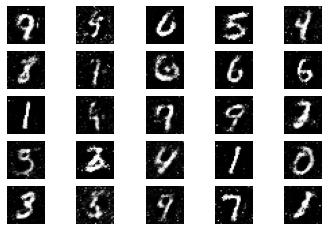

5000 [D loss real: 0.671, acc.: 59.38%] [D loss fake: 0.689, acc.: 50.00%] [G loss: 0.822, acc.: 31.25%]
5100 [D loss real: 0.684, acc.: 53.12%] [D loss fake: 0.694, acc.: 51.56%] [G loss: 0.853, acc.: 21.88%]
5200 [D loss real: 0.641, acc.: 60.94%] [D loss fake: 0.628, acc.: 64.06%] [G loss: 0.838, acc.: 25.00%]
5300 [D loss real: 0.740, acc.: 40.62%] [D loss fake: 0.731, acc.: 46.88%] [G loss: 0.815, acc.: 32.03%]
5400 [D loss real: 0.673, acc.: 59.38%] [D loss fake: 0.700, acc.: 57.81%] [G loss: 0.801, acc.: 23.44%]
5500 [D loss real: 0.743, acc.: 42.19%] [D loss fake: 0.655, acc.: 62.50%] [G loss: 0.788, acc.: 33.59%]
5600 [D loss real: 0.704, acc.: 48.44%] [D loss fake: 0.641, acc.: 59.38%] [G loss: 0.851, acc.: 23.44%]
5700 [D loss real: 0.682, acc.: 53.12%] [D loss fake: 0.708, acc.: 56.25%] [G loss: 0.802, acc.: 33.59%]
5800 [D loss real: 0.654, acc.: 59.38%] [D loss fake: 0.729, acc.: 48.44%] [G loss: 0.833, acc.: 21.88%]
5900 [D loss real: 0.708, acc.: 50.00%] [D loss fake: 0

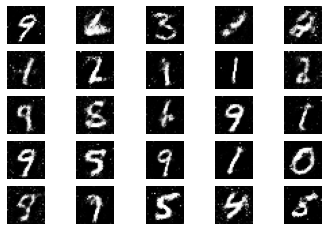

6000 [D loss real: 0.711, acc.: 46.88%] [D loss fake: 0.650, acc.: 62.50%] [G loss: 0.781, acc.: 32.03%]
6100 [D loss real: 0.630, acc.: 65.62%] [D loss fake: 0.707, acc.: 50.00%] [G loss: 0.811, acc.: 32.03%]
6200 [D loss real: 0.669, acc.: 60.94%] [D loss fake: 0.702, acc.: 56.25%] [G loss: 0.827, acc.: 28.91%]
6300 [D loss real: 0.729, acc.: 43.75%] [D loss fake: 0.686, acc.: 56.25%] [G loss: 0.802, acc.: 28.12%]
6400 [D loss real: 0.725, acc.: 35.94%] [D loss fake: 0.694, acc.: 57.81%] [G loss: 0.787, acc.: 38.28%]
6500 [D loss real: 0.673, acc.: 59.38%] [D loss fake: 0.751, acc.: 34.38%] [G loss: 0.799, acc.: 33.59%]
6600 [D loss real: 0.674, acc.: 57.81%] [D loss fake: 0.635, acc.: 70.31%] [G loss: 0.837, acc.: 25.78%]
6700 [D loss real: 0.641, acc.: 59.38%] [D loss fake: 0.703, acc.: 62.50%] [G loss: 0.805, acc.: 33.59%]
6800 [D loss real: 0.702, acc.: 56.25%] [D loss fake: 0.687, acc.: 59.38%] [G loss: 0.821, acc.: 26.56%]
6900 [D loss real: 0.693, acc.: 57.81%] [D loss fake: 0

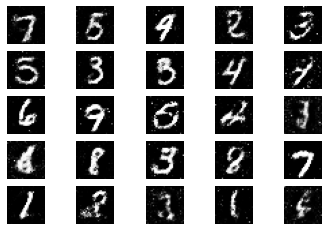

7000 [D loss real: 0.672, acc.: 50.00%] [D loss fake: 0.645, acc.: 73.44%] [G loss: 0.851, acc.: 28.91%]
7100 [D loss real: 0.679, acc.: 57.81%] [D loss fake: 0.729, acc.: 48.44%] [G loss: 0.785, acc.: 37.50%]
7200 [D loss real: 0.629, acc.: 65.62%] [D loss fake: 0.694, acc.: 60.94%] [G loss: 0.825, acc.: 32.03%]
7300 [D loss real: 0.678, acc.: 56.25%] [D loss fake: 0.770, acc.: 42.19%] [G loss: 0.816, acc.: 32.81%]
7400 [D loss real: 0.697, acc.: 54.69%] [D loss fake: 0.686, acc.: 56.25%] [G loss: 0.846, acc.: 25.78%]
7500 [D loss real: 0.644, acc.: 60.94%] [D loss fake: 0.677, acc.: 60.94%] [G loss: 0.792, acc.: 36.72%]
7600 [D loss real: 0.699, acc.: 48.44%] [D loss fake: 0.651, acc.: 62.50%] [G loss: 0.789, acc.: 33.59%]
7700 [D loss real: 0.726, acc.: 50.00%] [D loss fake: 0.727, acc.: 51.56%] [G loss: 0.837, acc.: 28.91%]
7800 [D loss real: 0.628, acc.: 67.19%] [D loss fake: 0.720, acc.: 54.69%] [G loss: 0.780, acc.: 37.50%]
7900 [D loss real: 0.705, acc.: 50.00%] [D loss fake: 0

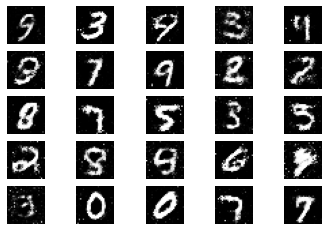

8000 [D loss real: 0.688, acc.: 53.12%] [D loss fake: 0.670, acc.: 60.94%] [G loss: 0.832, acc.: 25.00%]
8100 [D loss real: 0.725, acc.: 51.56%] [D loss fake: 0.636, acc.: 67.19%] [G loss: 0.792, acc.: 28.12%]
8200 [D loss real: 0.707, acc.: 43.75%] [D loss fake: 0.730, acc.: 51.56%] [G loss: 0.823, acc.: 29.69%]
8300 [D loss real: 0.689, acc.: 57.81%] [D loss fake: 0.657, acc.: 67.19%] [G loss: 0.827, acc.: 25.78%]
8400 [D loss real: 0.667, acc.: 59.38%] [D loss fake: 0.699, acc.: 50.00%] [G loss: 0.797, acc.: 34.38%]
8500 [D loss real: 0.671, acc.: 56.25%] [D loss fake: 0.704, acc.: 56.25%] [G loss: 0.781, acc.: 27.34%]
8600 [D loss real: 0.733, acc.: 45.31%] [D loss fake: 0.698, acc.: 59.38%] [G loss: 0.779, acc.: 31.25%]
8700 [D loss real: 0.667, acc.: 54.69%] [D loss fake: 0.731, acc.: 45.31%] [G loss: 0.793, acc.: 28.91%]
8800 [D loss real: 0.727, acc.: 43.75%] [D loss fake: 0.693, acc.: 62.50%] [G loss: 0.829, acc.: 25.78%]
8900 [D loss real: 0.637, acc.: 60.94%] [D loss fake: 0

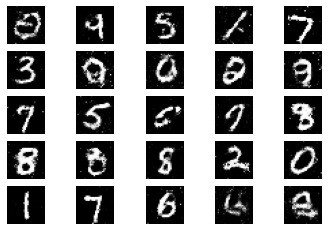

9000 [D loss real: 0.679, acc.: 57.81%] [D loss fake: 0.711, acc.: 45.31%] [G loss: 0.844, acc.: 28.91%]
9100 [D loss real: 0.692, acc.: 50.00%] [D loss fake: 0.694, acc.: 54.69%] [G loss: 0.773, acc.: 35.94%]
9200 [D loss real: 0.679, acc.: 57.81%] [D loss fake: 0.743, acc.: 40.62%] [G loss: 0.787, acc.: 32.81%]
9300 [D loss real: 0.654, acc.: 62.50%] [D loss fake: 0.746, acc.: 37.50%] [G loss: 0.819, acc.: 30.47%]
9400 [D loss real: 0.698, acc.: 50.00%] [D loss fake: 0.702, acc.: 53.12%] [G loss: 0.796, acc.: 28.91%]
9500 [D loss real: 0.721, acc.: 50.00%] [D loss fake: 0.712, acc.: 51.56%] [G loss: 0.791, acc.: 35.16%]
9600 [D loss real: 0.696, acc.: 53.12%] [D loss fake: 0.714, acc.: 54.69%] [G loss: 0.792, acc.: 37.50%]
9700 [D loss real: 0.713, acc.: 51.56%] [D loss fake: 0.663, acc.: 54.69%] [G loss: 0.762, acc.: 32.81%]
9800 [D loss real: 0.716, acc.: 42.19%] [D loss fake: 0.724, acc.: 51.56%] [G loss: 0.819, acc.: 22.66%]
9900 [D loss real: 0.725, acc.: 34.38%] [D loss fake: 0

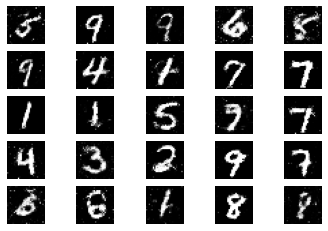

10000 [D loss real: 0.685, acc.: 54.69%] [D loss fake: 0.660, acc.: 67.19%] [G loss: 0.803, acc.: 32.03%]
CPU times: user 8min 23s, sys: 24.5 s, total: 8min 48s
Wall time: 8min 21s


In [ ]:
%%time
history = train(generator, discriminator, epochs=10000, batch_size=128, save_interval=1000)

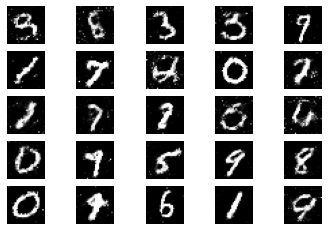

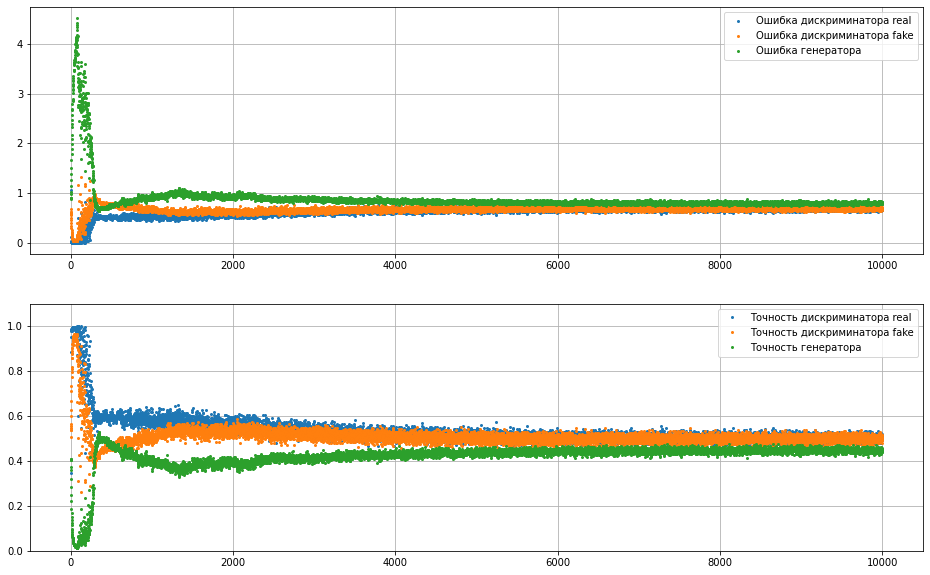

In [ ]:
plot_imgs(generator, latent_dim)
plot_history(history)

Такой график характерен для нормального обучения. Ошибки дискриминатора и генератора близки к друг другу и стремятся к некоторой постоянной величине.

Ошибки Д. и Г. не характеризуют степень качества генерируемых картинок. Обычно качество продолжает улучшаться по мере увеличения эпох, но на графике это не видно.

Если кривые ошибок Д. и Г. расходятся это означает несбалансированность. Например, если ошибка генератора растет, а ошибка дискриминатора стремится к нулю, это означает что дискриминатор "сильнее" генератора. В этом случае надо либо "усилить" (усложнить) генератор, либо упростить дискриминатор.


### Сверточный GAN

In [ ]:
def build_conv_generator(latent_dim=100):
    noise = Input(shape=(latent_dim,)) 
    
    x = Dense(7 * 7 * 128)(noise)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 128))(x)
    
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    img = Conv2D(1, (3, 3), activation='tanh', padding='same')(x)
    model = Model(noise, img, name='Generator')

    model.summary()

    return model    

In [ ]:
def build_conv_discriminator():
    input_img = Input(shape=img_shape)
    x = Conv2D(64, (3, 3), strides=(2, 2), padding="same")(input_img)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)  

    output = Dense(1, activation='sigmoid')(x)

    model = Model(input_img, output, name='Discriminator')
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
conv_gen = build_conv_generator()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       147584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       14

In [ ]:
conv_dis = build_conv_discriminator()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)        

100 [D loss real: 0.676, acc.: 62.50%] [D loss fake: 0.720, acc.: 54.69%] [G loss: 0.939, acc.: 30.47%]
200 [D loss real: 0.682, acc.: 51.56%] [D loss fake: 0.645, acc.: 60.94%] [G loss: 0.858, acc.: 24.22%]
300 [D loss real: 0.689, acc.: 48.44%] [D loss fake: 0.702, acc.: 51.56%] [G loss: 0.793, acc.: 31.25%]
400 [D loss real: 0.742, acc.: 37.50%] [D loss fake: 0.689, acc.: 50.00%] [G loss: 0.778, acc.: 27.34%]
500 [D loss real: 0.638, acc.: 65.62%] [D loss fake: 0.684, acc.: 50.00%] [G loss: 0.795, acc.: 27.34%]
600 [D loss real: 0.697, acc.: 53.12%] [D loss fake: 0.694, acc.: 59.38%] [G loss: 0.803, acc.: 29.69%]
700 [D loss real: 0.626, acc.: 64.06%] [D loss fake: 0.688, acc.: 50.00%] [G loss: 0.773, acc.: 30.47%]
800 [D loss real: 0.606, acc.: 71.88%] [D loss fake: 0.695, acc.: 60.94%] [G loss: 0.836, acc.: 23.44%]
900 [D loss real: 0.646, acc.: 59.38%] [D loss fake: 0.638, acc.: 68.75%] [G loss: 0.865, acc.: 21.88%]


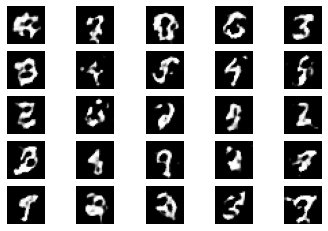

1000 [D loss real: 0.646, acc.: 56.25%] [D loss fake: 0.632, acc.: 57.81%] [G loss: 0.884, acc.: 21.88%]
1100 [D loss real: 0.697, acc.: 53.12%] [D loss fake: 0.628, acc.: 65.62%] [G loss: 0.892, acc.: 24.22%]
1200 [D loss real: 0.598, acc.: 73.44%] [D loss fake: 0.623, acc.: 68.75%] [G loss: 0.864, acc.: 32.03%]
1300 [D loss real: 0.613, acc.: 67.19%] [D loss fake: 0.682, acc.: 65.62%] [G loss: 0.869, acc.: 22.66%]
1400 [D loss real: 0.648, acc.: 60.94%] [D loss fake: 0.616, acc.: 68.75%] [G loss: 0.914, acc.: 21.09%]
1500 [D loss real: 0.643, acc.: 64.06%] [D loss fake: 0.660, acc.: 62.50%] [G loss: 0.860, acc.: 24.22%]
1600 [D loss real: 0.663, acc.: 64.06%] [D loss fake: 0.596, acc.: 81.25%] [G loss: 0.849, acc.: 26.56%]
1700 [D loss real: 0.723, acc.: 43.75%] [D loss fake: 0.656, acc.: 62.50%] [G loss: 0.863, acc.: 28.12%]
1800 [D loss real: 0.636, acc.: 59.38%] [D loss fake: 0.679, acc.: 60.94%] [G loss: 0.820, acc.: 30.47%]
1900 [D loss real: 0.651, acc.: 59.38%] [D loss fake: 0

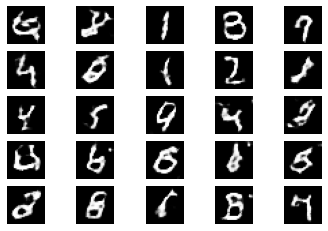

2000 [D loss real: 0.663, acc.: 59.38%] [D loss fake: 0.654, acc.: 59.38%] [G loss: 0.865, acc.: 26.56%]
2100 [D loss real: 0.642, acc.: 65.62%] [D loss fake: 0.653, acc.: 62.50%] [G loss: 0.810, acc.: 30.47%]
2200 [D loss real: 0.649, acc.: 60.94%] [D loss fake: 0.675, acc.: 57.81%] [G loss: 0.837, acc.: 23.44%]
2300 [D loss real: 0.652, acc.: 57.81%] [D loss fake: 0.668, acc.: 57.81%] [G loss: 0.799, acc.: 30.47%]
2400 [D loss real: 0.693, acc.: 57.81%] [D loss fake: 0.663, acc.: 62.50%] [G loss: 0.829, acc.: 29.69%]
2500 [D loss real: 0.639, acc.: 65.62%] [D loss fake: 0.643, acc.: 60.94%] [G loss: 0.782, acc.: 34.38%]
2600 [D loss real: 0.625, acc.: 62.50%] [D loss fake: 0.657, acc.: 65.62%] [G loss: 0.815, acc.: 35.94%]
2700 [D loss real: 0.652, acc.: 62.50%] [D loss fake: 0.681, acc.: 62.50%] [G loss: 0.788, acc.: 39.84%]
2800 [D loss real: 0.657, acc.: 64.06%] [D loss fake: 0.640, acc.: 71.88%] [G loss: 0.780, acc.: 35.94%]
2900 [D loss real: 0.687, acc.: 54.69%] [D loss fake: 0

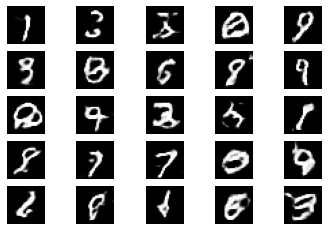

3000 [D loss real: 0.627, acc.: 68.75%] [D loss fake: 0.631, acc.: 70.31%] [G loss: 0.844, acc.: 25.00%]
3100 [D loss real: 0.643, acc.: 60.94%] [D loss fake: 0.695, acc.: 48.44%] [G loss: 0.798, acc.: 32.03%]
3200 [D loss real: 0.681, acc.: 46.88%] [D loss fake: 0.701, acc.: 57.81%] [G loss: 0.788, acc.: 32.81%]
3300 [D loss real: 0.668, acc.: 57.81%] [D loss fake: 0.698, acc.: 50.00%] [G loss: 0.837, acc.: 23.44%]
3400 [D loss real: 0.659, acc.: 60.94%] [D loss fake: 0.682, acc.: 56.25%] [G loss: 0.849, acc.: 22.66%]
3500 [D loss real: 0.627, acc.: 68.75%] [D loss fake: 0.657, acc.: 64.06%] [G loss: 0.788, acc.: 38.28%]
3600 [D loss real: 0.644, acc.: 59.38%] [D loss fake: 0.672, acc.: 70.31%] [G loss: 0.836, acc.: 28.91%]
3700 [D loss real: 0.718, acc.: 54.69%] [D loss fake: 0.657, acc.: 56.25%] [G loss: 0.860, acc.: 22.66%]
3800 [D loss real: 0.638, acc.: 62.50%] [D loss fake: 0.635, acc.: 65.62%] [G loss: 0.789, acc.: 35.94%]
3900 [D loss real: 0.714, acc.: 46.88%] [D loss fake: 0

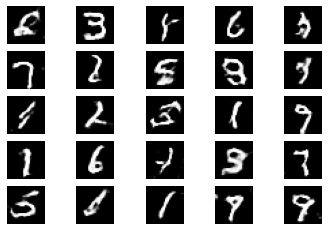

4000 [D loss real: 0.688, acc.: 46.88%] [D loss fake: 0.620, acc.: 65.62%] [G loss: 0.793, acc.: 36.72%]
4100 [D loss real: 0.649, acc.: 64.06%] [D loss fake: 0.701, acc.: 54.69%] [G loss: 0.844, acc.: 26.56%]
4200 [D loss real: 0.693, acc.: 50.00%] [D loss fake: 0.586, acc.: 81.25%] [G loss: 0.835, acc.: 31.25%]
4300 [D loss real: 0.623, acc.: 68.75%] [D loss fake: 0.638, acc.: 73.44%] [G loss: 0.812, acc.: 32.81%]
4400 [D loss real: 0.643, acc.: 62.50%] [D loss fake: 0.643, acc.: 60.94%] [G loss: 0.797, acc.: 32.03%]
4500 [D loss real: 0.667, acc.: 57.81%] [D loss fake: 0.672, acc.: 57.81%] [G loss: 0.840, acc.: 27.34%]
4600 [D loss real: 0.620, acc.: 59.38%] [D loss fake: 0.663, acc.: 64.06%] [G loss: 0.824, acc.: 32.03%]
4700 [D loss real: 0.662, acc.: 62.50%] [D loss fake: 0.702, acc.: 50.00%] [G loss: 0.816, acc.: 31.25%]
4800 [D loss real: 0.674, acc.: 54.69%] [D loss fake: 0.633, acc.: 68.75%] [G loss: 0.818, acc.: 31.25%]
4900 [D loss real: 0.663, acc.: 57.81%] [D loss fake: 0

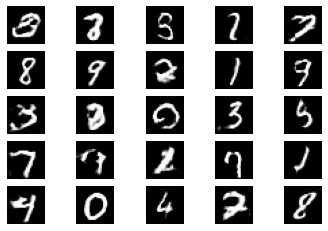

5000 [D loss real: 0.645, acc.: 59.38%] [D loss fake: 0.659, acc.: 64.06%] [G loss: 0.797, acc.: 33.59%]
5100 [D loss real: 0.666, acc.: 64.06%] [D loss fake: 0.660, acc.: 67.19%] [G loss: 0.815, acc.: 29.69%]
5200 [D loss real: 0.687, acc.: 51.56%] [D loss fake: 0.685, acc.: 59.38%] [G loss: 0.757, acc.: 42.97%]
5300 [D loss real: 0.663, acc.: 60.94%] [D loss fake: 0.647, acc.: 64.06%] [G loss: 0.838, acc.: 27.34%]
5400 [D loss real: 0.665, acc.: 54.69%] [D loss fake: 0.638, acc.: 59.38%] [G loss: 0.837, acc.: 31.25%]
5500 [D loss real: 0.683, acc.: 51.56%] [D loss fake: 0.627, acc.: 73.44%] [G loss: 0.868, acc.: 17.97%]
5600 [D loss real: 0.634, acc.: 67.19%] [D loss fake: 0.710, acc.: 51.56%] [G loss: 0.831, acc.: 29.69%]
5700 [D loss real: 0.714, acc.: 43.75%] [D loss fake: 0.683, acc.: 59.38%] [G loss: 0.802, acc.: 32.81%]
5800 [D loss real: 0.667, acc.: 51.56%] [D loss fake: 0.660, acc.: 60.94%] [G loss: 0.830, acc.: 28.91%]
5900 [D loss real: 0.698, acc.: 51.56%] [D loss fake: 0

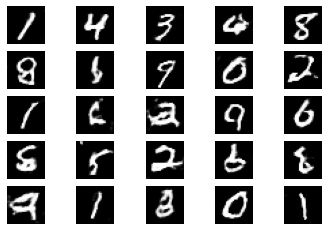

6000 [D loss real: 0.638, acc.: 68.75%] [D loss fake: 0.667, acc.: 59.38%] [G loss: 0.824, acc.: 29.69%]
6100 [D loss real: 0.658, acc.: 64.06%] [D loss fake: 0.670, acc.: 60.94%] [G loss: 0.856, acc.: 22.66%]
6200 [D loss real: 0.650, acc.: 59.38%] [D loss fake: 0.641, acc.: 64.06%] [G loss: 0.778, acc.: 36.72%]
6300 [D loss real: 0.646, acc.: 60.94%] [D loss fake: 0.698, acc.: 56.25%] [G loss: 0.830, acc.: 32.81%]
6400 [D loss real: 0.691, acc.: 50.00%] [D loss fake: 0.671, acc.: 60.94%] [G loss: 0.814, acc.: 34.38%]
6500 [D loss real: 0.680, acc.: 57.81%] [D loss fake: 0.648, acc.: 65.62%] [G loss: 0.809, acc.: 33.59%]
6600 [D loss real: 0.665, acc.: 56.25%] [D loss fake: 0.657, acc.: 56.25%] [G loss: 0.852, acc.: 25.00%]
6700 [D loss real: 0.739, acc.: 43.75%] [D loss fake: 0.656, acc.: 65.62%] [G loss: 0.781, acc.: 37.50%]
6800 [D loss real: 0.640, acc.: 62.50%] [D loss fake: 0.666, acc.: 64.06%] [G loss: 0.825, acc.: 28.12%]
6900 [D loss real: 0.686, acc.: 53.12%] [D loss fake: 0

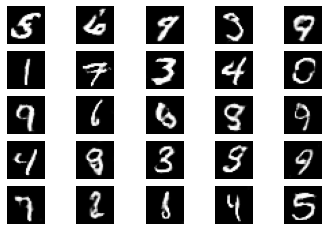

7000 [D loss real: 0.705, acc.: 46.88%] [D loss fake: 0.678, acc.: 57.81%] [G loss: 0.830, acc.: 28.91%]
7100 [D loss real: 0.645, acc.: 68.75%] [D loss fake: 0.632, acc.: 65.62%] [G loss: 0.844, acc.: 28.12%]
7200 [D loss real: 0.653, acc.: 59.38%] [D loss fake: 0.661, acc.: 65.62%] [G loss: 0.842, acc.: 33.59%]
7300 [D loss real: 0.633, acc.: 60.94%] [D loss fake: 0.670, acc.: 56.25%] [G loss: 0.826, acc.: 34.38%]
7400 [D loss real: 0.664, acc.: 53.12%] [D loss fake: 0.708, acc.: 51.56%] [G loss: 0.833, acc.: 24.22%]
7500 [D loss real: 0.639, acc.: 54.69%] [D loss fake: 0.641, acc.: 65.62%] [G loss: 0.830, acc.: 26.56%]
7600 [D loss real: 0.671, acc.: 57.81%] [D loss fake: 0.652, acc.: 70.31%] [G loss: 0.792, acc.: 32.03%]
7700 [D loss real: 0.661, acc.: 54.69%] [D loss fake: 0.661, acc.: 59.38%] [G loss: 0.826, acc.: 30.47%]
7800 [D loss real: 0.646, acc.: 60.94%] [D loss fake: 0.689, acc.: 60.94%] [G loss: 0.847, acc.: 22.66%]
7900 [D loss real: 0.674, acc.: 57.81%] [D loss fake: 0

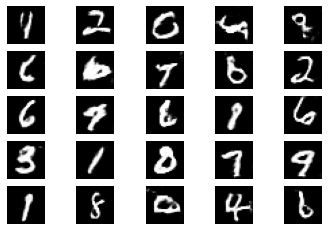

8000 [D loss real: 0.655, acc.: 64.06%] [D loss fake: 0.665, acc.: 64.06%] [G loss: 0.831, acc.: 27.34%]
8100 [D loss real: 0.606, acc.: 64.06%] [D loss fake: 0.677, acc.: 59.38%] [G loss: 0.817, acc.: 30.47%]
8200 [D loss real: 0.686, acc.: 57.81%] [D loss fake: 0.655, acc.: 57.81%] [G loss: 0.813, acc.: 30.47%]
8300 [D loss real: 0.662, acc.: 62.50%] [D loss fake: 0.649, acc.: 56.25%] [G loss: 0.847, acc.: 25.78%]
8400 [D loss real: 0.671, acc.: 56.25%] [D loss fake: 0.637, acc.: 67.19%] [G loss: 0.840, acc.: 28.91%]
8500 [D loss real: 0.677, acc.: 56.25%] [D loss fake: 0.640, acc.: 68.75%] [G loss: 0.859, acc.: 30.47%]
8600 [D loss real: 0.658, acc.: 57.81%] [D loss fake: 0.663, acc.: 68.75%] [G loss: 0.796, acc.: 35.94%]
8700 [D loss real: 0.686, acc.: 51.56%] [D loss fake: 0.678, acc.: 54.69%] [G loss: 0.842, acc.: 29.69%]
8800 [D loss real: 0.626, acc.: 70.31%] [D loss fake: 0.676, acc.: 67.19%] [G loss: 0.844, acc.: 26.56%]
8900 [D loss real: 0.615, acc.: 67.19%] [D loss fake: 0

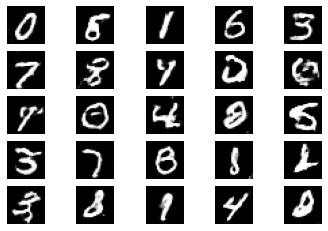

9000 [D loss real: 0.625, acc.: 67.19%] [D loss fake: 0.694, acc.: 64.06%] [G loss: 0.767, acc.: 37.50%]
9100 [D loss real: 0.664, acc.: 60.94%] [D loss fake: 0.712, acc.: 50.00%] [G loss: 0.820, acc.: 35.16%]
9200 [D loss real: 0.643, acc.: 67.19%] [D loss fake: 0.633, acc.: 65.62%] [G loss: 0.783, acc.: 32.81%]
9300 [D loss real: 0.656, acc.: 56.25%] [D loss fake: 0.657, acc.: 65.62%] [G loss: 0.813, acc.: 28.91%]
9400 [D loss real: 0.677, acc.: 53.12%] [D loss fake: 0.705, acc.: 60.94%] [G loss: 0.828, acc.: 32.81%]
9500 [D loss real: 0.624, acc.: 65.62%] [D loss fake: 0.641, acc.: 59.38%] [G loss: 0.815, acc.: 32.81%]
9600 [D loss real: 0.645, acc.: 57.81%] [D loss fake: 0.668, acc.: 64.06%] [G loss: 0.814, acc.: 32.81%]
9700 [D loss real: 0.693, acc.: 50.00%] [D loss fake: 0.722, acc.: 48.44%] [G loss: 0.811, acc.: 28.91%]
9800 [D loss real: 0.653, acc.: 57.81%] [D loss fake: 0.667, acc.: 57.81%] [G loss: 0.809, acc.: 34.38%]
9900 [D loss real: 0.621, acc.: 71.88%] [D loss fake: 0

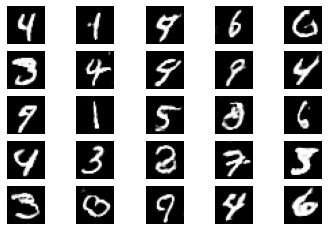

10000 [D loss real: 0.658, acc.: 59.38%] [D loss fake: 0.659, acc.: 60.94%] [G loss: 0.788, acc.: 34.38%]
CPU times: user 9min 24s, sys: 26.3 s, total: 9min 50s
Wall time: 12min 12s


In [ ]:
%%time
history = train(conv_gen, conv_dis, epochs=10000, batch_size=128, save_interval=1000)

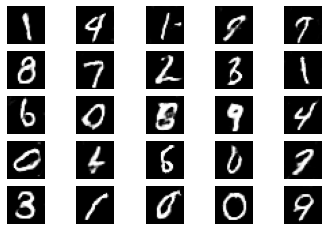

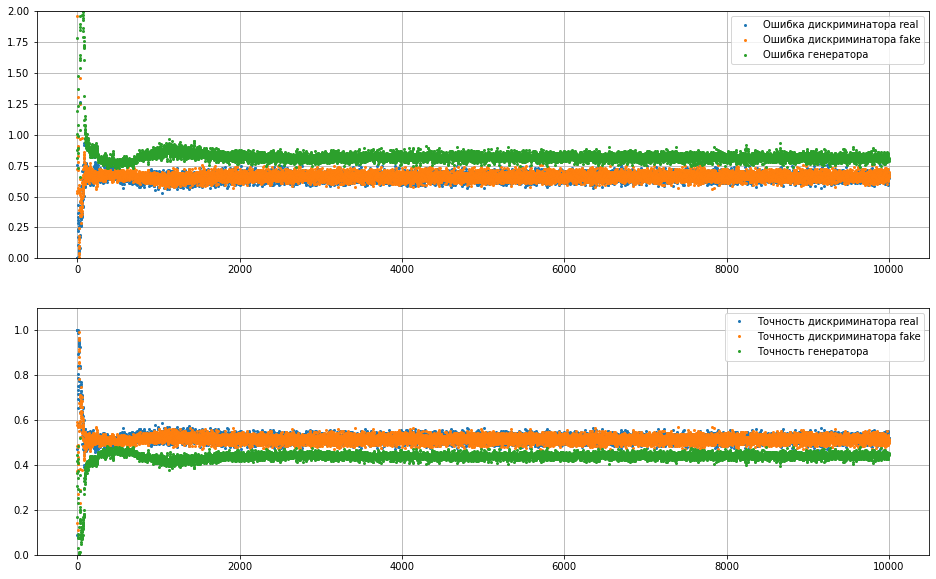

In [ ]:
plot_imgs(conv_gen, 100)
plot_history(history, ylim=(0,2))

Сверточная GAN дает более четкие картинки по сравнению с полносвязной.

## CGAN - GAN c условием.

GAN с условием получается добавлением на входы генератора и дискриминатора меток (классов) изображений. Генератор учится получать из шума картинки определенных классов (как указано в метке)

In [ ]:
def build_cond_generator():
    noise = Input(shape=(latent_dim,)) 
    label_cat = Input(shape=(num_classes,))

    x = Concatenate()([noise, label_cat])
    
    x = Dense(7 * 7 * 128)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 128))(x)
    
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    img = Conv2D(1, (3, 3), activation='tanh', padding='same')(x)
    model = Model([noise, label_cat], img, name='Generator')
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    model.summary()

    return model

In [ ]:
def build_cond_discriminator():
    input_img = Input(shape=img_shape)
    label_cat = Input(shape=(num_classes))

    x = Conv2D(32, (3, 3), strides=(2,2), padding="same")(input_img)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), strides=(2,2), padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), strides=(2,2), padding="same")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    
    x = Dense(256)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)  

    x = Dense(32)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)  

    x = concatenate([x, label_cat])

    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.2)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model([input_img, label_cat], output, name='Discriminator')
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
cgen = build_cond_generator()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 6272)         696192      concatenate[0][0]        

In [ ]:
cdis = build_cond_discriminator()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   320         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 14, 14, 32)   128         conv2d_4[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_14 (LeakyReLU)      (None, 14, 14, 32)   0           batch_normalization_4[0][0]      
______________________________________________________________________________________

In [ ]:
def sample_images_conditional(epoch, gen, noise, labels, r=2, c=5):  
    gen_imgs = gen.predict([noise, labels]) 
    gen_imgs = 0.5 * gen_imgs + 0.5 # Трансформируем значения в диапазон от 0 до 1

    fig, axs = plt.subplots(r, c) # Создаем окно вывода r на c (2 на 5) ячеек
    cnt = 0 
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray') 
            axs[i,j].axis('off') 
            cnt += 1 
    fig.suptitle(f"Generated images after {epoch} epochs", fontsize=12)
    # plt.savefig('images2/{:05d}.png'.format(epoch))
    plt.show()  
    plt.close()

### Функция обучения с условием

In [ ]:
def train_conditional(generator, discriminator, epochs=30000, batch_size=128, sample_interval=1000):
    # Грузим датасеты
    (x_mnist, y_mnist), (_, _) = mnist.load_data()

    X_mnist = (x_mnist - 127.5) / 128.
    X_mnist = np.expand_dims(X_mnist, axis=3)
    Y_mnist_cat = to_categorical(y_mnist, num_classes) 

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    noise = Input(shape=(latent_dim,))
    label_cat = Input(shape=(num_classes,)) # OHE
    img = generator([noise, label_cat])
    validity = discriminator([img, label_cat])

    combined = Model([noise, label_cat], validity)
    combined.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    history = []

    r, c = 2, 5
    NOISE = np.random.normal(0, 1, (r * c, latent_dim))
    LABELS = np.eye(10)
    
    for epoch in range(epochs):
        idx = np.random.randint(0, X_mnist.shape[0], batch_size)
        valid_imgs, labels_num, labels_cat = X_mnist[idx], y_mnist[idx], Y_mnist_cat[idx] 

        # Картинки из шума для обучения генератора
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict([noise, labels_cat])

        # Обучите дискриминатор и получите ошибки
        d_loss_real = discriminator.train_on_batch([valid_imgs, labels_cat], valid)
        d_loss_fake = discriminator.train_on_batch([fake_imgs, labels_cat], fake)
        d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

        # Обучите генератор
        idx = np.random.randint(0, X_mnist.shape[0], batch_size)
        labels_num, labels_cat = y_mnist[idx], Y_mnist_cat[idx] 
        g_loss = combined.train_on_batch([noise, labels_cat], valid)

        if epoch % 100 == 0:
             print ("%d [D loss real: %.3f, acc.: %.2f%%] [D loss fake: %.3f, acc.: %.2f%%] [G loss: %.3f, acc.: %.2f%%]" % 
                   (epoch + 1, d_loss_real[0], 100*d_loss_real[1], d_loss_fake[0], 100*d_loss_fake[1], g_loss[0], 100*g_loss[1]))

        history.append((d_loss_real, d_loss_fake, g_loss))
        
        if ((epoch+1) % sample_interval == 0):
            sample_images_conditional(epoch+1, generator, NOISE, LABELS, r=r, c=c)

    return np.array(history)

1 [D loss real: 0.605, acc.: 64.06%] [D loss fake: 1.021, acc.: 17.97%] [G loss: 0.581, acc.: 72.66%]
101 [D loss real: 0.350, acc.: 100.00%] [D loss fake: 1.106, acc.: 0.00%] [G loss: 0.437, acc.: 99.22%]
201 [D loss real: 0.353, acc.: 100.00%] [D loss fake: 1.065, acc.: 0.78%] [G loss: 0.444, acc.: 99.22%]
301 [D loss real: 0.380, acc.: 99.22%] [D loss fake: 1.068, acc.: 0.00%] [G loss: 0.441, acc.: 100.00%]
401 [D loss real: 0.370, acc.: 100.00%] [D loss fake: 1.043, acc.: 0.00%] [G loss: 0.444, acc.: 100.00%]
501 [D loss real: 0.366, acc.: 100.00%] [D loss fake: 1.064, acc.: 0.00%] [G loss: 0.446, acc.: 97.66%]
601 [D loss real: 0.355, acc.: 99.22%] [D loss fake: 1.067, acc.: 0.78%] [G loss: 0.453, acc.: 100.00%]
701 [D loss real: 0.340, acc.: 100.00%] [D loss fake: 1.064, acc.: 0.00%] [G loss: 0.453, acc.: 99.22%]
801 [D loss real: 0.340, acc.: 100.00%] [D loss fake: 1.058, acc.: 0.78%] [G loss: 0.444, acc.: 99.22%]
901 [D loss real: 0.339, acc.: 100.00%] [D loss fake: 1.057, acc.

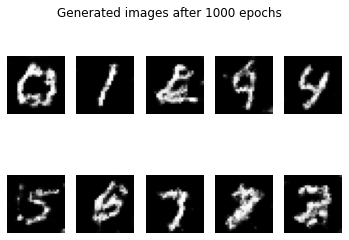

1001 [D loss real: 0.360, acc.: 100.00%] [D loss fake: 1.079, acc.: 0.00%] [G loss: 0.444, acc.: 100.00%]
1101 [D loss real: 0.360, acc.: 100.00%] [D loss fake: 1.054, acc.: 0.78%] [G loss: 0.444, acc.: 99.22%]
1201 [D loss real: 0.338, acc.: 100.00%] [D loss fake: 1.063, acc.: 0.00%] [G loss: 0.441, acc.: 99.22%]
1301 [D loss real: 0.367, acc.: 100.00%] [D loss fake: 1.064, acc.: 0.00%] [G loss: 0.460, acc.: 100.00%]
1401 [D loss real: 0.358, acc.: 100.00%] [D loss fake: 1.081, acc.: 0.78%] [G loss: 0.431, acc.: 100.00%]
1501 [D loss real: 0.349, acc.: 100.00%] [D loss fake: 1.064, acc.: 0.78%] [G loss: 0.437, acc.: 100.00%]
1601 [D loss real: 0.361, acc.: 100.00%] [D loss fake: 1.069, acc.: 0.00%] [G loss: 0.436, acc.: 100.00%]
1701 [D loss real: 0.362, acc.: 100.00%] [D loss fake: 1.066, acc.: 0.00%] [G loss: 0.432, acc.: 100.00%]
1801 [D loss real: 0.365, acc.: 100.00%] [D loss fake: 1.053, acc.: 0.00%] [G loss: 0.433, acc.: 100.00%]
1901 [D loss real: 0.370, acc.: 100.00%] [D loss

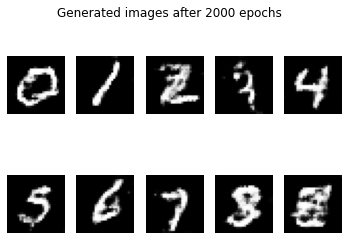

2001 [D loss real: 0.354, acc.: 100.00%] [D loss fake: 1.075, acc.: 0.00%] [G loss: 0.445, acc.: 100.00%]
2101 [D loss real: 0.362, acc.: 100.00%] [D loss fake: 1.058, acc.: 0.78%] [G loss: 0.441, acc.: 100.00%]
2201 [D loss real: 0.357, acc.: 100.00%] [D loss fake: 1.073, acc.: 0.00%] [G loss: 0.430, acc.: 100.00%]
2301 [D loss real: 0.365, acc.: 100.00%] [D loss fake: 1.102, acc.: 0.00%] [G loss: 0.441, acc.: 100.00%]
2401 [D loss real: 0.357, acc.: 100.00%] [D loss fake: 1.063, acc.: 0.00%] [G loss: 0.424, acc.: 100.00%]
2501 [D loss real: 0.382, acc.: 99.22%] [D loss fake: 1.077, acc.: 0.78%] [G loss: 0.433, acc.: 99.22%]
2601 [D loss real: 0.368, acc.: 100.00%] [D loss fake: 1.080, acc.: 0.00%] [G loss: 0.434, acc.: 100.00%]
2701 [D loss real: 0.382, acc.: 100.00%] [D loss fake: 1.096, acc.: 0.00%] [G loss: 0.427, acc.: 100.00%]
2801 [D loss real: 0.375, acc.: 100.00%] [D loss fake: 1.073, acc.: 0.00%] [G loss: 0.418, acc.: 99.22%]
2901 [D loss real: 0.383, acc.: 100.00%] [D loss 

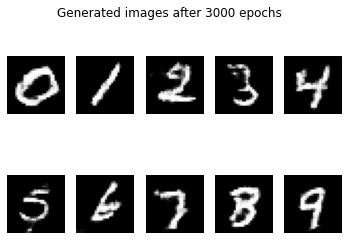

3001 [D loss real: 0.396, acc.: 100.00%] [D loss fake: 1.095, acc.: 0.78%] [G loss: 0.444, acc.: 99.22%]
3101 [D loss real: 0.390, acc.: 100.00%] [D loss fake: 1.105, acc.: 0.00%] [G loss: 0.433, acc.: 100.00%]
3201 [D loss real: 0.388, acc.: 100.00%] [D loss fake: 1.092, acc.: 0.00%] [G loss: 0.419, acc.: 100.00%]
3301 [D loss real: 0.388, acc.: 100.00%] [D loss fake: 1.088, acc.: 0.00%] [G loss: 0.420, acc.: 100.00%]
3401 [D loss real: 0.370, acc.: 100.00%] [D loss fake: 1.094, acc.: 0.00%] [G loss: 0.434, acc.: 99.22%]
3501 [D loss real: 0.398, acc.: 100.00%] [D loss fake: 1.083, acc.: 0.00%] [G loss: 0.420, acc.: 100.00%]
3601 [D loss real: 0.380, acc.: 100.00%] [D loss fake: 1.115, acc.: 0.00%] [G loss: 0.414, acc.: 100.00%]
3701 [D loss real: 0.378, acc.: 100.00%] [D loss fake: 1.108, acc.: 0.00%] [G loss: 0.434, acc.: 100.00%]
3801 [D loss real: 0.383, acc.: 100.00%] [D loss fake: 1.101, acc.: 0.00%] [G loss: 0.411, acc.: 99.22%]
3901 [D loss real: 0.388, acc.: 100.00%] [D loss 

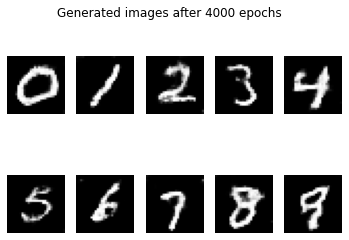

4001 [D loss real: 0.368, acc.: 100.00%] [D loss fake: 1.102, acc.: 0.00%] [G loss: 0.434, acc.: 100.00%]
4101 [D loss real: 0.379, acc.: 100.00%] [D loss fake: 1.090, acc.: 0.00%] [G loss: 0.425, acc.: 99.22%]
4201 [D loss real: 0.380, acc.: 100.00%] [D loss fake: 1.068, acc.: 0.00%] [G loss: 0.432, acc.: 100.00%]
4301 [D loss real: 0.390, acc.: 100.00%] [D loss fake: 1.086, acc.: 0.00%] [G loss: 0.431, acc.: 100.00%]
4401 [D loss real: 0.380, acc.: 100.00%] [D loss fake: 1.088, acc.: 0.00%] [G loss: 0.431, acc.: 100.00%]
4501 [D loss real: 0.383, acc.: 100.00%] [D loss fake: 1.084, acc.: 0.00%] [G loss: 0.422, acc.: 100.00%]
4601 [D loss real: 0.373, acc.: 100.00%] [D loss fake: 1.085, acc.: 0.00%] [G loss: 0.433, acc.: 100.00%]
4701 [D loss real: 0.388, acc.: 100.00%] [D loss fake: 1.050, acc.: 0.00%] [G loss: 0.432, acc.: 100.00%]
4801 [D loss real: 0.385, acc.: 100.00%] [D loss fake: 1.061, acc.: 0.00%] [G loss: 0.423, acc.: 100.00%]
4901 [D loss real: 0.385, acc.: 100.00%] [D los

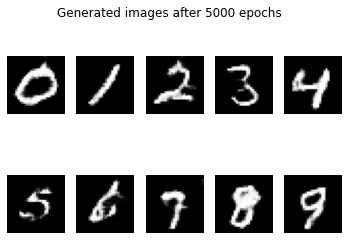

5001 [D loss real: 0.388, acc.: 100.00%] [D loss fake: 1.078, acc.: 0.00%] [G loss: 0.429, acc.: 100.00%]
5101 [D loss real: 0.387, acc.: 100.00%] [D loss fake: 1.102, acc.: 0.00%] [G loss: 0.431, acc.: 100.00%]
5201 [D loss real: 0.376, acc.: 100.00%] [D loss fake: 1.087, acc.: 0.00%] [G loss: 0.409, acc.: 100.00%]
5301 [D loss real: 0.372, acc.: 100.00%] [D loss fake: 1.062, acc.: 0.00%] [G loss: 0.413, acc.: 100.00%]
5401 [D loss real: 0.401, acc.: 100.00%] [D loss fake: 1.109, acc.: 0.00%] [G loss: 0.412, acc.: 100.00%]
5501 [D loss real: 0.390, acc.: 100.00%] [D loss fake: 1.076, acc.: 0.78%] [G loss: 0.419, acc.: 100.00%]
5601 [D loss real: 0.380, acc.: 100.00%] [D loss fake: 1.117, acc.: 0.00%] [G loss: 0.418, acc.: 100.00%]
5701 [D loss real: 0.379, acc.: 100.00%] [D loss fake: 1.099, acc.: 0.00%] [G loss: 0.414, acc.: 100.00%]
5801 [D loss real: 0.402, acc.: 100.00%] [D loss fake: 1.091, acc.: 0.00%] [G loss: 0.414, acc.: 100.00%]
5901 [D loss real: 0.388, acc.: 100.00%] [D lo

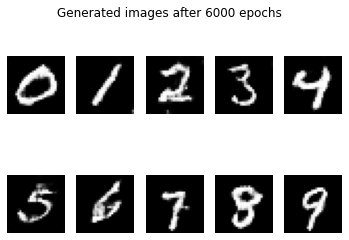

6001 [D loss real: 0.386, acc.: 100.00%] [D loss fake: 1.103, acc.: 0.00%] [G loss: 0.421, acc.: 100.00%]
6101 [D loss real: 0.401, acc.: 100.00%] [D loss fake: 1.087, acc.: 0.00%] [G loss: 0.414, acc.: 100.00%]
6201 [D loss real: 0.393, acc.: 100.00%] [D loss fake: 1.094, acc.: 0.00%] [G loss: 0.428, acc.: 100.00%]
6301 [D loss real: 0.394, acc.: 100.00%] [D loss fake: 1.106, acc.: 0.00%] [G loss: 0.418, acc.: 100.00%]
6401 [D loss real: 0.396, acc.: 100.00%] [D loss fake: 1.102, acc.: 0.00%] [G loss: 0.416, acc.: 100.00%]
6501 [D loss real: 0.389, acc.: 100.00%] [D loss fake: 1.087, acc.: 0.00%] [G loss: 0.428, acc.: 100.00%]
6601 [D loss real: 0.380, acc.: 100.00%] [D loss fake: 1.073, acc.: 0.00%] [G loss: 0.427, acc.: 100.00%]
6701 [D loss real: 0.389, acc.: 100.00%] [D loss fake: 1.113, acc.: 0.00%] [G loss: 0.419, acc.: 100.00%]
6801 [D loss real: 0.387, acc.: 100.00%] [D loss fake: 1.098, acc.: 0.00%] [G loss: 0.419, acc.: 100.00%]
6901 [D loss real: 0.400, acc.: 100.00%] [D lo

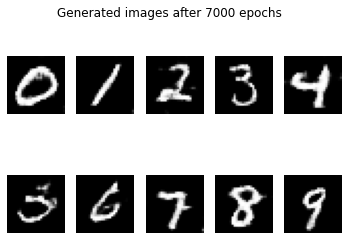

7001 [D loss real: 0.388, acc.: 100.00%] [D loss fake: 1.057, acc.: 0.78%] [G loss: 0.418, acc.: 100.00%]
7101 [D loss real: 0.399, acc.: 100.00%] [D loss fake: 1.072, acc.: 0.00%] [G loss: 0.413, acc.: 100.00%]
7201 [D loss real: 0.388, acc.: 100.00%] [D loss fake: 1.099, acc.: 0.78%] [G loss: 0.418, acc.: 100.00%]
7301 [D loss real: 0.394, acc.: 100.00%] [D loss fake: 1.111, acc.: 0.00%] [G loss: 0.425, acc.: 100.00%]
7401 [D loss real: 0.386, acc.: 100.00%] [D loss fake: 1.089, acc.: 0.00%] [G loss: 0.422, acc.: 100.00%]
7501 [D loss real: 0.385, acc.: 100.00%] [D loss fake: 1.095, acc.: 0.00%] [G loss: 0.420, acc.: 100.00%]
7601 [D loss real: 0.393, acc.: 100.00%] [D loss fake: 1.082, acc.: 0.00%] [G loss: 0.430, acc.: 100.00%]
7701 [D loss real: 0.388, acc.: 100.00%] [D loss fake: 1.094, acc.: 0.00%] [G loss: 0.412, acc.: 100.00%]
7801 [D loss real: 0.401, acc.: 100.00%] [D loss fake: 1.097, acc.: 0.00%] [G loss: 0.415, acc.: 100.00%]
7901 [D loss real: 0.407, acc.: 100.00%] [D lo

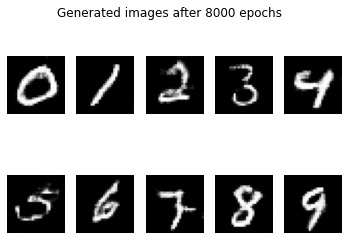

8001 [D loss real: 0.385, acc.: 100.00%] [D loss fake: 1.090, acc.: 0.00%] [G loss: 0.422, acc.: 100.00%]
8101 [D loss real: 0.404, acc.: 100.00%] [D loss fake: 1.085, acc.: 0.00%] [G loss: 0.414, acc.: 100.00%]
8201 [D loss real: 0.393, acc.: 100.00%] [D loss fake: 1.092, acc.: 0.00%] [G loss: 0.413, acc.: 100.00%]
8301 [D loss real: 0.402, acc.: 100.00%] [D loss fake: 1.092, acc.: 0.00%] [G loss: 0.426, acc.: 100.00%]
8401 [D loss real: 0.375, acc.: 100.00%] [D loss fake: 1.108, acc.: 0.00%] [G loss: 0.416, acc.: 100.00%]
8501 [D loss real: 0.408, acc.: 100.00%] [D loss fake: 1.074, acc.: 0.00%] [G loss: 0.423, acc.: 100.00%]
8601 [D loss real: 0.388, acc.: 100.00%] [D loss fake: 1.085, acc.: 0.00%] [G loss: 0.411, acc.: 100.00%]
8701 [D loss real: 0.389, acc.: 100.00%] [D loss fake: 1.104, acc.: 0.00%] [G loss: 0.409, acc.: 100.00%]
8801 [D loss real: 0.389, acc.: 100.00%] [D loss fake: 1.086, acc.: 0.00%] [G loss: 0.418, acc.: 100.00%]
8901 [D loss real: 0.396, acc.: 100.00%] [D lo

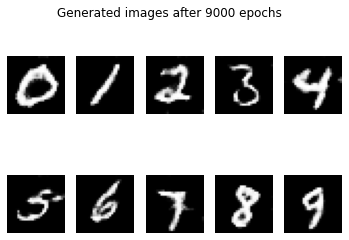

9001 [D loss real: 0.390, acc.: 100.00%] [D loss fake: 1.123, acc.: 0.00%] [G loss: 0.432, acc.: 100.00%]
9101 [D loss real: 0.388, acc.: 100.00%] [D loss fake: 1.095, acc.: 0.00%] [G loss: 0.401, acc.: 100.00%]
9201 [D loss real: 0.405, acc.: 100.00%] [D loss fake: 1.104, acc.: 0.00%] [G loss: 0.410, acc.: 100.00%]
9301 [D loss real: 0.382, acc.: 100.00%] [D loss fake: 1.081, acc.: 0.00%] [G loss: 0.401, acc.: 100.00%]
9401 [D loss real: 0.396, acc.: 100.00%] [D loss fake: 1.114, acc.: 0.00%] [G loss: 0.419, acc.: 100.00%]
9501 [D loss real: 0.386, acc.: 100.00%] [D loss fake: 1.095, acc.: 0.00%] [G loss: 0.415, acc.: 100.00%]
9601 [D loss real: 0.392, acc.: 100.00%] [D loss fake: 1.110, acc.: 0.00%] [G loss: 0.411, acc.: 100.00%]
9701 [D loss real: 0.387, acc.: 100.00%] [D loss fake: 1.093, acc.: 0.00%] [G loss: 0.414, acc.: 100.00%]
9801 [D loss real: 0.388, acc.: 100.00%] [D loss fake: 1.100, acc.: 0.00%] [G loss: 0.418, acc.: 100.00%]
9901 [D loss real: 0.394, acc.: 100.00%] [D lo

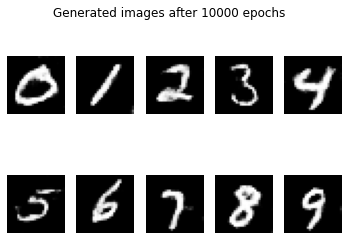

CPU times: user 11min 11s, sys: 29.8 s, total: 11min 41s
Wall time: 13min 34s


In [ ]:
%%time
history = train_conditional(cgen, cdis, epochs=10000, batch_size=128)

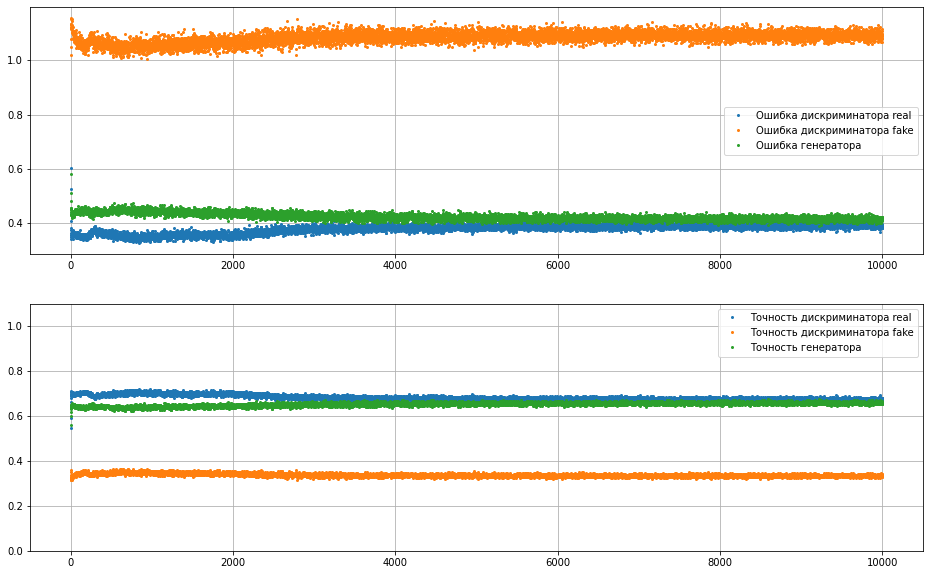

In [ ]:
plot_history(history)

# Литература

1. https://habr.com/ru/company/wunderfund/blog/334568/
2. https://neerc.ifmo.ru/wiki/index.php?title=Generative_Adversarial_Nets_(GAN)#.D0.9A.D0.BE.D0.BB.D0.BB.D0.B0.D0.BF.D1.81_.D0.BC.D0.BE.D0.B4
3. https://neurohive.io/ru/osnovy-data-science/gan-rukovodstvo-dlja-novichkov/
4. https://evergreens.com.ua/ru/articles/gan.html
5. https://proglib.io/p/generativno-sostyazatelnaya-neyroset-vasha-pervaya-gan-model-na-pytorch-2020-08-11
6. https://medium.com/@neurohiveru/%D0%BF%D1%80%D0%BE%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B2%D0%BD%D1%8B%D0%B5-%D0%B3%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B8-gan-%D0%BE%D1%82-nvidia-%D0%B1%D1%8B%D1%81%D1%82%D1%80%D0%BE%D0%B5-%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5-%D0%B8-%D0%B2%D1%8B%D1%81%D0%BE%D0%BA%D0%BE%D0%B5-ad49fa87c967
7. https://www.youtube.com/watch?v=_zyh1mzXDqQ
